# Sparkify Churn Prediction

## Contents <a id="top">
* [0. Business Objective](#bizobj)
* [1. Setting Up](#setup)
* [2. Data Exploration / Preliminary Pre-processing](#dataexplore)
* [3. Feature Engineering](#feature)
* [4. Modelling](#model)
* [5. Value Proposition](#value)


## 0. Business Objective <a id="bizobj">
[back to top](#top)

### 0.1 Defining Churn

> **Customer churn** is a tendency of customers to abandon a brand and stop being a paying client of a particular business. The percentage of customers that discontinue using a company’s products or services during a particular time period is called a customer churn (attrition) rate.

For this project, we will define **churn** as when a user cancels the service. In the dataset, this is identified as having a value of ```Cancellation Confirmation``` under column ```page```.

### 0.2 Business Problem

Churn is a problem for Sparkify as it represents revenue lost from subscribers who leave the platform. There is revenue lost from subscribers who previously paid for the subscription. 
Thus, the challenge is to identify these potential churn users before they actually cancel their subscription, and to employ appropriate countermeasure to prevent churn.

### 0.3 Solution Approach

In order to identify users who will potentially cancel their subscription, we will be attempting various machine learning techniques. These techniques will utilize data from past usage behaviour to identify the probability of a particular user eventually cancelling the subscription to Sparkify.

## 1. Setting Up <a id="setup">
[back to top](#top)

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_json('./Data.json', lines=True)

In [3]:
data.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


## 2. Exploratory Data Analysis / Preliminary Pre-processing <a id="dataexplore">
[back to top](#top)

### 2.0 Overview

#### 2.0.1 Number of Observations

In [4]:
print("There are {} number of observations".format(len(data)))

There are 543705 number of observations


#### 2.0.2 Columns with null values

In [5]:
data.isna().sum()

ts                    0
userId                0
sessionId             0
page                  0
auth                  0
method                0
status                0
level                 0
itemInSession         0
location          15700
userAgent         15700
lastName          15700
firstName         15700
registration      15700
gender            15700
artist           110828
song             110828
length           110828
dtype: int64

The breakdown of null values indicate that there are observations with null values across many columns such as `location`, `userAgent`. We will likely want to remove them since these observations with many missing values will not contain sufficient information for us to use in modelling.

In [6]:
print("All Columns with null values: \n{} ".format(data.columns[data.isna().any()].tolist()))

All Columns with null values: 
['location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length'] 


In [7]:
print("Let's take a look at some of the rows with missing data: \n")
data.loc[:, data.isna().any()].head()

Let's take a look at some of the rows with missing data: 



,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1.532064e+12,M,Martin Orford,Grand Designs,597.55057
1,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1.538070e+12,M,John Brown's Body,Bulls,380.21179
2,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,Afroman,Because I Got High,202.37016
3,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1.535953e+12,M,NaN,NaN,NaN
4,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342


#### 2.0.3 Categorical / Numerical Columns

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ts             543705 non-null  int64  
 1   userId         543705 non-null  object 
 2   sessionId      543705 non-null  int64  
 3   page           543705 non-null  object 
 4   auth           543705 non-null  object 
 5   method         543705 non-null  object 
 6   status         543705 non-null  int64  
 7   level          543705 non-null  object 
 8   itemInSession  543705 non-null  int64  
 9   location       528005 non-null  object 
 10  userAgent      528005 non-null  object 
 11  lastName       528005 non-null  object 
 12  firstName      528005 non-null  object 
 13  registration   528005 non-null  float64
 14  gender         528005 non-null  object 
 15  artist         432877 non-null  object 
 16  song           432877 non-null  object 
 17  length         432877 non-nul

Numerical: ts, userId, sessionId, itemInSession, registration, length     
Categorical: page, auth, method, status, level, location, userAgent, gender

##### 2.0.3.1 Overview of Numerical Columns

ts: Timestamp of the log  
userId: User's id   
sessionId: A session id   
itemInSession: Log count in the session    
registration: User's registration timestamp   
Length: Song's length in seconds

#### 2.1.1 How many distinct users?

In [9]:
print("There are {} distinct users".format(data["userId"].nunique()))

There are 449 distinct users


#### 2.1.2 What are the unique page values?

In [10]:
print("Total unique page values :", len(data["page"].unique()))

# Print the count of each unique page value
print(data["page"].value_counts())

Total unique page values : 22
NextSong                     432877
Home                          27412
Thumbs Up                     23826
Add to Playlist               12349
Add Friend                     8087
Roll Advert                    7773
Login                          6011
Logout                         5990
Thumbs Down                    4911
Downgrade                      3811
Help                           3150
Settings                       2964
About                          1855
Upgrade                         968
Save Settings                   585
Error                           519
Submit Upgrade                  287
Submit Downgrade                117
Cancel                           99
Cancellation Confirmation        99
Register                         11
Submit Registration               4
Name: page, dtype: int64


**Unique page values**: NextSong, Home, Thumps Up, Add to Playlist, Add Friend, Roll Advert, Login, Logout, Thumbs Down, Downgrade, Help, Settings, About, Upgrade, Save Settings, Error, Submit Upgrade, Submit Downgrade, Cancel, Cancellation Confirmation, Register, Submit Registration.

Specifically `Cancellation Confirmation` will be what we use to identify churned users

### 2.2 Preprocessing: Creating ```churn``` binary label


In [11]:
churn = data.loc[data["page"] == "Cancellation Confirmation"]
print("There are {} customers that churn.".format(churn["userId"].nunique()))

# userId of all the churn users
churn_users = churn["userId"]


## a list of users that cancel the service
churn_users = churn_users.tolist()

There are 99 customers that churn.


In [12]:
# Adding a new column "churn"
data["churn"] = data["userId"].isin(churn_users)

allusers = data["userId"].unique()

# a list of users that uses the service
nonchurn_users = [x for x in allusers if x not in churn_users]

# label the new churn column True or False

churn_df = pd.DataFrame(columns = ["userId", "churn"])
for user in churn_users:
    churn_df = churn_df.append({"userId":user, "churn": True}, ignore_index = True)
for user in nonchurn_users:
    churn_df = churn_df.append({"userId":user, "churn": False}, ignore_index = True)

In [13]:
#dataframe containing the churn and non-churn users
churn_df

,userId,churn
0,208,True
1,231,True
2,236,True
3,156,True
4,271,True
...,...,...
444,300028,False
445,300051,False
446,300026,False
447,300039,False


### 2.3 ```gender```

#### 2.3.1 What is the gender distribution like for churn vs non-churn users?

In [14]:
# Print the number of male and females for churn
churn["gender"].value_counts()

M    54
F    45
Name: gender, dtype: int64

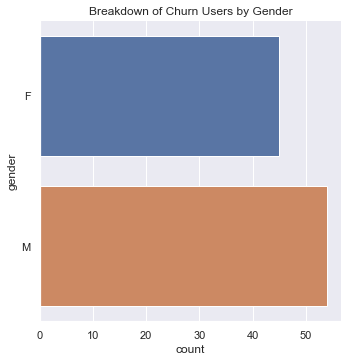

In [15]:
# Gender of the Churn Customers
sb.catplot(y = 'gender', data = churn, kind = "count")
plt.title('Breakdown of Churn Users by Gender')
plt.show()

In [16]:
# Print the number of male and females for non-churn
nonchurn = data.loc[~(data["userId"].isin(churn_users))]
nonchurn_gender = nonchurn.groupby(["userId"])["gender"].unique().reset_index()
nonchurn_gender = nonchurn_gender.explode("gender")
nonchurn_gender["gender"].value_counts()

M    196
F    153
Name: gender, dtype: int64

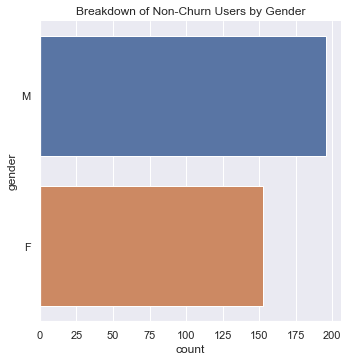

In [17]:
# Gender of the non-churn Customers
nonchurn = data.loc[~(data["userId"].isin(churn_users))]
nonchurn_gender = nonchurn.groupby(["userId"])["gender"].unique().reset_index()
nonchurn_gender = nonchurn_gender.explode("gender")
nonchurn_gender

sb.catplot(y = 'gender', data = nonchurn_gender, kind = "count")
plt.title('Breakdown of Non-Churn Users by Gender')
plt.show()

Out of 99 customers that churn, 54 are male and 45 are females.

Out of 350 customeers that do not churn, 196 are male and 153 are females.

There are more males using the service as compared to females. There are also more males that churn as compared to females.

### 2.4 ```datetime```

In [18]:
from datetime import datetime

In [19]:
def get_datetime (unix):
    date_time = datetime.fromtimestamp(unix/1000)
    return date_time

In [20]:
data["ts"] = data["ts"].astype(float)
data["datetime"] = data["ts"].apply(get_datetime)

In [21]:
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,registration,gender,artist,song,length,churn,datetime,year,month,day
0,1.538352e+12,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,1.532064e+12,M,Martin Orford,Grand Designs,597.55057,True,2018-10-01 08:00:11,2018,10,0
1,1.538352e+12,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,1.538070e+12,M,John Brown's Body,Bulls,380.21179,False,2018-10-01 08:00:25,2018,10,0
2,1.538352e+12,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,1.535953e+12,M,Afroman,Because I Got High,202.37016,False,2018-10-01 08:01:58,2018,10,0
3,1.538352e+12,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,1.535953e+12,M,NaN,NaN,NaN,False,2018-10-01 08:01:59,2018,10,0
4,1.538352e+12,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,1.535931e+12,F,Lily Allen,Smile (Radio Edit),194.53342,True,2018-10-01 08:02:04,2018,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543700,1.543622e+12,300010,882,NextSong,Logged In,PUT,200,paid,165,"Dallas-Fort Worth-Arlington, TX",...,1.536850e+12,M,Oliver Onions,Dune Buggy,183.50975,False,2018-12-01 07:58:36,2018,12,5
543701,1.543622e+12,300049,991,NextSong,Logged In,PUT,200,paid,145,"Fresno, CA",...,1.537523e+12,M,Sheena Easton,Strut (1993 Digital Remaster),239.62077,False,2018-12-01 07:58:52,2018,12,5
543702,1.543622e+12,300039,916,NextSong,Logged In,PUT,200,paid,31,"Memphis, TN-MS-AR",...,1.536229e+12,M,The White Stripes,Jolene [Live],234.97098,False,2018-12-01 07:59:28,2018,12,5
543703,1.543622e+12,300038,966,NextSong,Logged In,PUT,200,paid,36,"Lakeland-Winter Haven, FL",...,1.535616e+12,M,Hinder,Lips Of An Angel,262.05995,False,2018-12-01 07:59:52,2018,12,5


#### 2.4.1 Time-trend of user count according to churn status

In [22]:
temp = data[data['churn'] == True]
temp = temp[temp['page']=='NextSong']
temp['hour'] = temp['datetime'].dt.hour
temp['US_hour'] = temp['hour'] - 4
temp['US_hour'] = temp['US_hour'].apply(lambda x: x + 24 if x < 0 else x)

res = temp.groupby('US_hour')['userId'].nunique().sort_values(ascending=False).reset_index()
res.rename(columns={'userId': 'userCount'}, inplace=True)
res_2 = temp.groupby('US_hour')['userId'].count().sort_values(ascending=False).reset_index()
res_2.rename(columns={'userId': 'songCount'}, inplace=True)
res = res.merge(res_2, on='US_hour', how='left')
res.head()

,US_hour,userCount,songCount
0,20,83,4461
1,21,82,4643
2,19,81,4242
3,17,80,3470
4,22,79,4599


In [23]:
temp = data[data['churn'] == False]
temp = temp[temp['page']=='NextSong']
temp['hour'] = temp['datetime'].dt.hour
temp['US_hour'] = temp['hour'] - 4
temp['US_hour'] = temp['US_hour'].apply(lambda x: x + 24 if x < 0 else x)

res_no = temp.groupby('US_hour')['userId'].nunique().sort_values(ascending=False).reset_index()
res_no.rename(columns={'userId': 'userCount'}, inplace=True)
res_no_2 = temp.groupby('US_hour')['userId'].count().sort_values(ascending=False).reset_index()
res_no_2.rename(columns={'userId': 'songCount'}, inplace=True)
res_no = res_no.merge(res_no_2, on='US_hour', how='left')
res_no.head()

,US_hour,userCount,songCount
0,20,300,18081
1,19,300,17711
2,22,294,17624
3,21,293,17857
4,18,293,16206


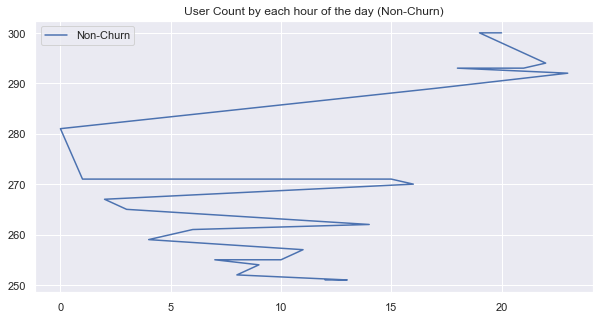

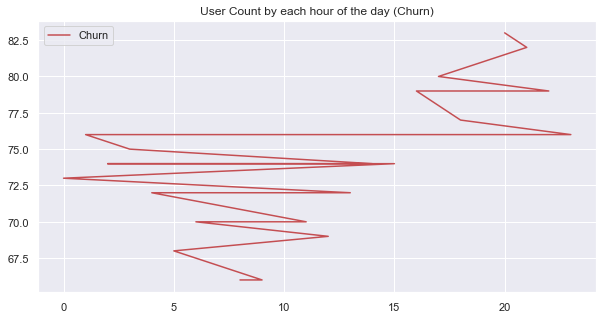

In [24]:
plt.plot(res_no['US_hour'], res_no['userCount'], label='Non-Churn')
plt.title('User Count by each hour of the day (Non-Churn)')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend()
plt.show()

plt.plot(res['US_hour'], res['userCount'], label='Churn', c='r')
plt.title('User Count by each hour of the day (Churn)')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend()
plt.show()

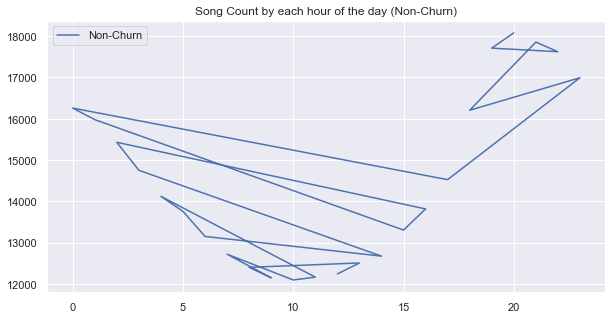

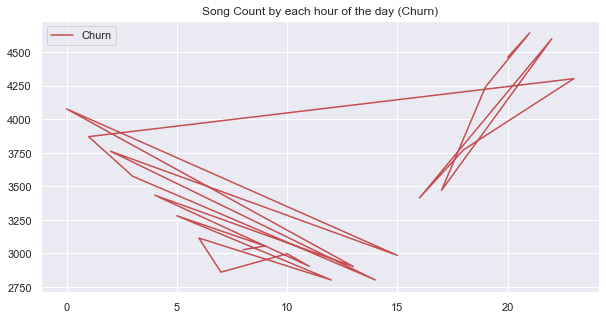

In [25]:
plt.plot(res_no['US_hour'], res_no['songCount'], label='Non-Churn')
plt.title('Song Count by each hour of the day (Non-Churn)')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend()
plt.show()

plt.plot(res['US_hour'], res['songCount'], label='Churn', c='r')
plt.title('Song Count by each hour of the day (Churn)')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend()
plt.show()

In [26]:
res = res.sort_values('US_hour')
res_no = res_no.sort_values('US_hour')

In [27]:
# Create new column to calcualte average song per user

res['songPerUser'] = res['songCount'] / res['userCount']
res_no['songPerUser'] = res_no['songCount'] / res_no['userCount']

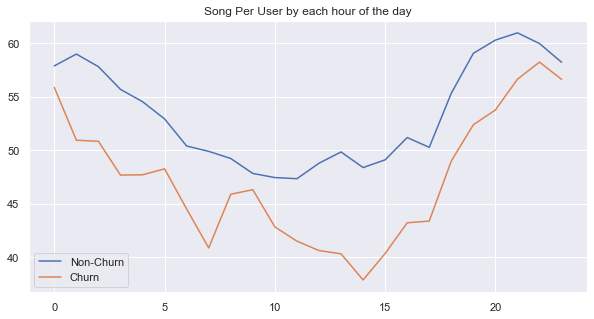

In [28]:
plt.plot(res_no['US_hour'], res_no['songPerUser'], label='Non-Churn')
plt.plot(res['US_hour'], res['songPerUser'], label='Churn')
plt.title('Song Per User by each hour of the day')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.legend()
plt.show()

In general, we observe that across both churn and non-churn groups, there is most activity in terms of users, songs and songs per users in the later parts of the day (peaking around Hour 21 which is 9pm) and has the least activity in the middle of the day around noon to 3pm, arguably when most people are at work.

Interestingly, we also observe that on average the average number of songs per user for the churn group is consistently lower than that of the non-churn group. This suggests that perhaps the churn group is not sufficiently engaged with the application, or unable to find suitable songs to continue listening, which is indicative of their likelihood of churning.

#### 2.5.1 Number of Unique Locations

In [29]:
print('Here is a sample of locations: \n{}'.format(data['location'].unique()[:5]))

Here is a sample of locations: 
['Corpus Christi, TX' 'Houston-The Woodlands-Sugar Land, TX'
 'Orlando-Kissimmee-Sanford, FL' 'Mobile, AL' 'Rochester, MN']


In [30]:
print("There are {} unique locations".format(data["location"].nunique()))

There are 192 unique locations


#### 2.5.2 User by Location

In [31]:
location = pd.DataFrame(data['location'])
userid = pd.DataFrame(data['userId'])
user_location = pd.concat([userid, location], axis = 1)
user_location = user_location.drop_duplicates("userId")
user_location

,userId,location
0,293,"Corpus Christi, TX"
1,98,"Houston-The Woodlands-Sugar Land, TX"
2,179,"Orlando-Kissimmee-Sanford, FL"
4,246,"Mobile, AL"
5,163,"Rochester, MN"
...,...,...
491863,300028,"Riverside-San Bernardino-Ontario, CA"
505002,300051,"Pittsburgh, PA"
508816,300026,"Cincinnati, OH-KY-IN"
519120,300039,"Memphis, TN-MS-AR"


### 2.6 Number of sessions per month

In [32]:
#Average number of sessions per month for each user
session_month = data.groupby(["userId","month"])["sessionId"].nunique().reset_index()
session_month = session_month.groupby("userId")["sessionId"].mean().reset_index()
session_month = session_month.rename(columns = {"sessionId":"session per month"})
session_month = session_month[session_month['userId']!='']
session_month

,userId,session per month
1,10,1.000000
2,100,13.333333
3,100001,3.000000
4,100002,2.000000
5,100003,4.500000
...,...,...
444,95,15.500000
445,96,9.000000
446,97,14.500000
447,98,10.000000


In [33]:
session_month.describe()

,session per month
count,448.000000
mean,6.754836
std,5.981960
min,1.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,35.500000


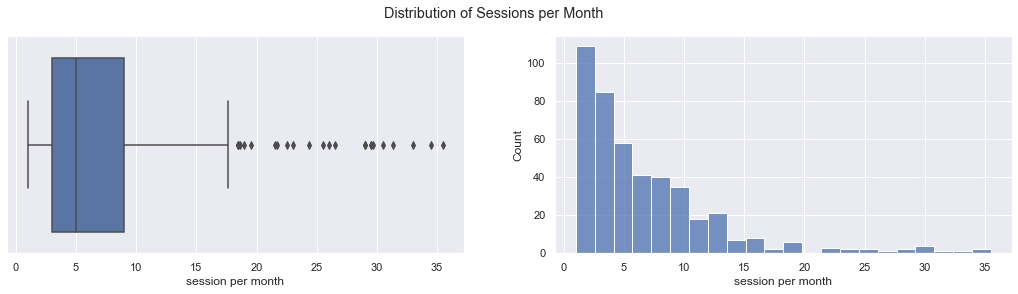

In [34]:
# NUMBER OF SESSION PER MONTH
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = session_month['session per month'], ax=axes[0])
sb.histplot(x = session_month['session per month'], ax=axes[1])
plt.suptitle('Distribution of Sessions per Month')
plt.show()

The average number of sessions per month is 5. Approximately 110 users clocked around 1 sessions per month, which is the highest.

### 2.7 Average number of songs per day and per month

In [35]:
#Average number of songs per day for each user
averagesongs_day = data.groupby(["userId","datetime"])["song"].nunique().reset_index()
averagesongs_day = averagesongs_day.groupby("userId")["song"].mean().reset_index()
averagesongs_day = averagesongs_day.rename(columns = {"song":"song per day"})
averagesongs_day

,userId,song per day
0,,0.000000
1,10,0.855107
2,100,0.848896
3,100001,0.721805
4,100002,0.778409
...,...,...
444,95,0.845082
445,96,0.848195
446,97,0.779145
447,98,0.838901


In [36]:
averagesongs_day.describe()

,song per day
count,449.000000
mean,0.797147
std,0.063825
min,0.000000
25%,0.773163
50%,0.809145
75%,0.833693
max,0.960000


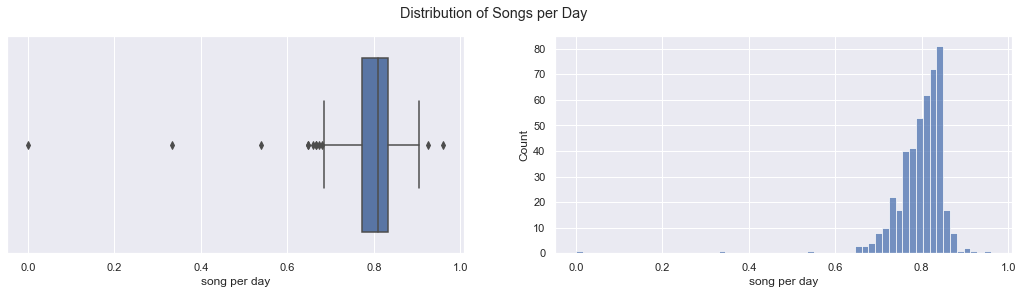

In [37]:
# NUMBER OF SONGS PER DAY
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = averagesongs_day['song per day'], ax=axes[0])
sb.histplot(x = averagesongs_day['song per day'], ax=axes[1])
plt.suptitle('Distribution of Songs per Day')
plt.show()

The average number of songs per day is 0.81. Approximately 80 users listened to 0.81 songs per day, which is the highest.

In [38]:
#Average number of songs per month for each user
averagesongs_month = data.groupby(["userId","month"])["song"].nunique().reset_index()
averagesongs_month = averagesongs_month.groupby("userId")["song"].mean().reset_index()
averagesongs_month = averagesongs_month.rename(columns = {"song":"song per month"})
averagesongs_month

,userId,song per month
0,,0.000000
1,10,350.000000
2,100,1007.333333
3,100001,96.000000
4,100002,68.500000
...,...,...
444,95,940.000000
445,96,905.500000
446,97,569.000000
447,98,809.666667


In [39]:
averagesongs_month.describe()

,song per month
count,449.000000
mean,429.160356
std,445.571591
min,0.000000
25%,109.000000
50%,290.500000
75%,594.000000
max,2633.000000


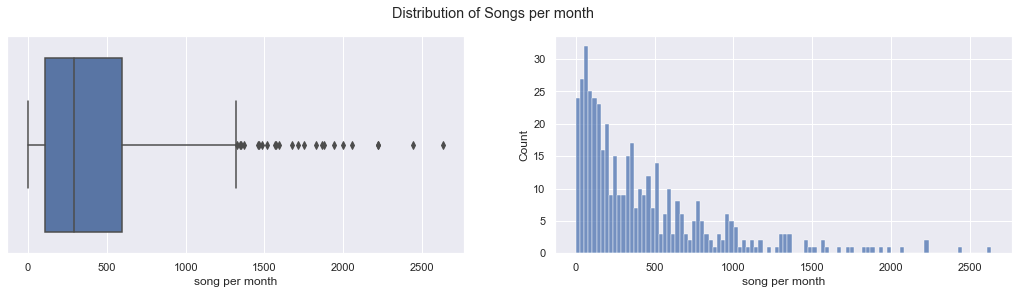

In [40]:
# NUMBER OF SONGS PER MONTH
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = averagesongs_month['song per month'], ax=axes[0])
sb.histplot(x = averagesongs_month['song per month'], ax=axes[1], bins=100)
plt.suptitle('Distribution of Songs per month')
plt.show()

The average number of songs per month is 290. Approximately 33 users listened to 75 songs per month, which is the highest.

### 2.8 Number of days since registration

In [41]:
#Create a column called “days_since_registration” which calculates the number of days since registration

#creating a list of registration date excluding Nan
subset = data[~(data["registration"].isna())]
subset["registration"] = subset["registration"].apply(get_datetime)
registration = subset.groupby("userId")["registration"].unique().reset_index().explode("registration")

#creating a list of the last entry excluding Nan
subset1 = data[~(data["ts"].isna())]
subset["ts"] = subset["ts"].apply(get_datetime)
ts = subset.groupby("userId")["ts"].max().reset_index().explode("ts")
ts

days_since_registration = registration.merge(ts)
days_since_registration["days_since_registration"] = days_since_registration["ts"] - days_since_registration["registration"]
days_since_registration["days_since_registration"] = days_since_registration["days_since_registration"].apply(lambda x: x.days)
days_since_registration = days_since_registration.drop(columns = ["registration", "ts"])
days_since_registration

,userId,days_since_registration
0,10,10
1,100,65
2,100001,44
3,100002,129
4,100003,50
...,...,...
443,95,59
444,96,70
445,97,86
446,98,63


In [42]:
days_since_registration.describe()

,days_since_registration
count,448.000000
mean,82.337054
std,40.534905
min,-1.000000
25%,60.000000
50%,76.000000
75%,99.000000
max,390.000000


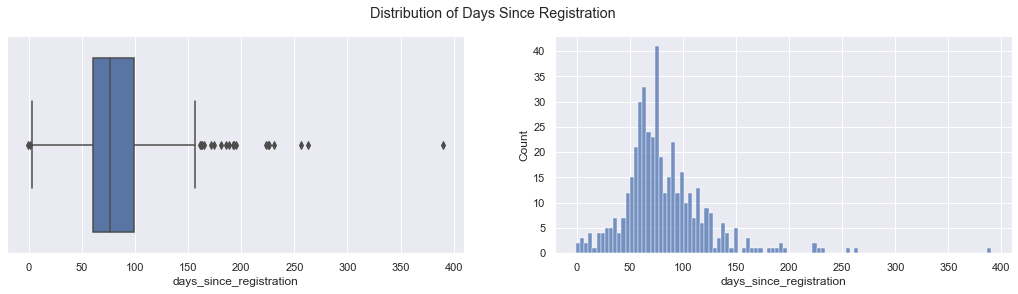

In [43]:
# NUMBER OF DAYS SINCE REGISTRATION
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = days_since_registration['days_since_registration'], ax=axes[0])
sb.histplot(x = days_since_registration['days_since_registration'], ax=axes[1], bins=100)
plt.suptitle('Distribution of Days Since Registration')
plt.show()

The average number of days since registration is 76. Approximately 41 users clocked in at 70 days since registration, which is the highest.

Variable 'time-trend of user count according to churn status' seems to be the most helpful in predicting whether users will churn. The lower the number of songs listened to, the higher the probability of the users churning.

## 3. Feature Engineering <a id="dataexplore">
[back to top](#top)

#### 3.1 Gender

In [44]:
#Create a column for gender

userId = pd.DataFrame(data['userId'])
gender = pd.DataFrame(data['gender'])
individual_gender = pd.concat([userId, gender], axis = 1)
individual_gender = individual_gender.drop_duplicates("userId")
individual_gender

,userId,gender
0,293,M
1,98,M
2,179,M
4,246,F
5,163,F
...,...,...
491863,300028,F
505002,300051,M
508816,300026,F
519120,300039,M


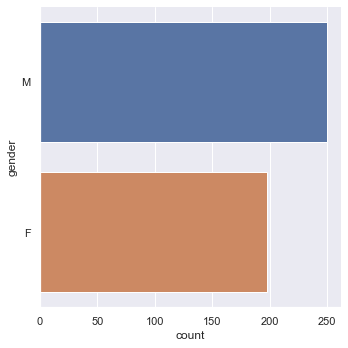

In [45]:
# Gender
sb.catplot(y = 'gender', data = individual_gender, kind = "count")

There are 250 males and 199 females using the service.

#### 3.2 Number of Artists listened to

In [46]:
#Create a column for number of unique artists they listen to

unique_artists = data.groupby("userId")["artist"].nunique().reset_index()
unique_artists

,userId,artist
0,,0
1,10,306
2,100,1963
3,100001,93
4,100002,128
...,...,...
444,95,1329
445,96,1339
446,97,905
447,98,1678


In [47]:
unique_artists.describe()

,artist
count,449.000000
mean,657.512249
std,625.956800
min,0.000000
25%,172.000000
50%,464.000000
75%,951.000000
max,3507.000000


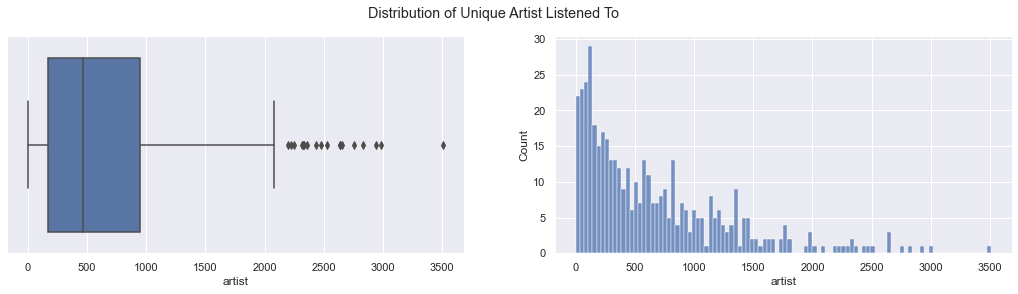

In [48]:
# NUMBER OF UNIQUE ARTISTES
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = unique_artists['artist'], ax=axes[0])
sb.histplot(x = unique_artists['artist'], ax=axes[1], bins=100)
plt.suptitle('Distribution of Unique Artist Listened To')
plt.show()

The average number of unique artists listened to is 464. Approximately 29 users listened to 133 different unique artist, which is the highest.

#### 3.3 Number of friends

In [49]:
# For every Add Friend page, we count it as 1 friend for that user
subset2 = data[data["page"] == "Add Friend"]
friends = subset2.groupby("userId").size().reset_index()
friends = friends.rename(columns = {0:"friends"})
friends

,userId,friends
0,10,3
1,100,71
2,100001,1
3,100003,8
4,100004,7
...,...,...
404,95,38
405,96,36
406,97,24
407,98,39


In [50]:
friends.describe()

,friends
count,409.000000
mean,19.772616
std,22.494436
min,1.000000
25%,5.000000
50%,12.000000
75%,26.000000
max,158.000000


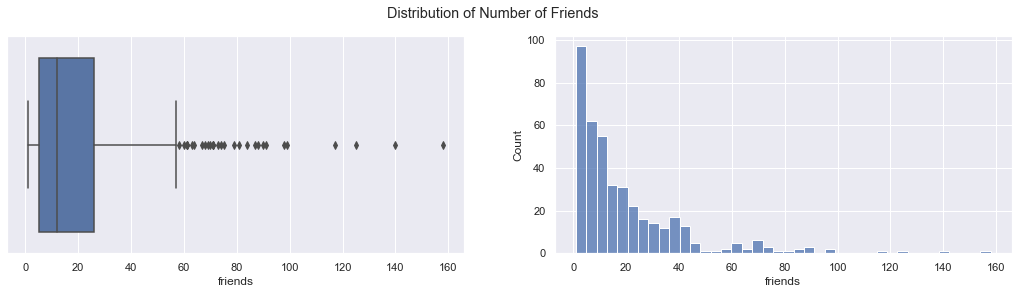

In [51]:
# NUMBER OF FRIENDS
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = friends['friends'], ax=axes[0])
sb.histplot(x = friends['friends'], ax=axes[1], bins=40)
plt.suptitle('Distribution of Number of Friends')
plt.show()

The average number of friends is 12. Approximately 98 users have 5 friends, which is the highest.

#### 3.4 Number of thumbs down

In [52]:
# For every Thumbs Down page, we count it as 1 Thumbs down for that user
subset4 = data[data["page"] == "Thumbs Down"]
thumbs_down = subset4.groupby("userId").size().reset_index()
thumbs_down = thumbs_down.rename(columns = {0:"thumbs down"})
thumbs_down

,userId,thumbs down
0,10,1
1,100,37
2,100001,1
3,100002,2
4,100003,10
...,...,...
384,95,21
385,96,20
386,97,10
387,98,31


In [53]:
thumbs_down.describe()

,thumbs down
count,389.000000
mean,12.624679
std,13.582433
min,1.000000
25%,3.000000
50%,8.000000
75%,17.000000
max,80.000000


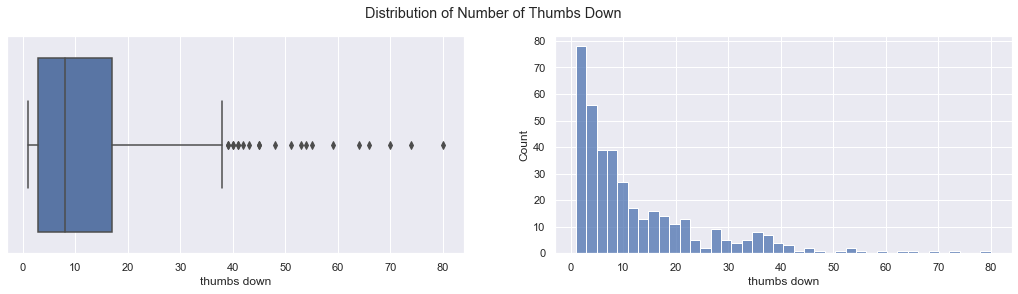

In [54]:
# NUMBER OF THUMBS DOWN
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = thumbs_down['thumbs down'], ax=axes[0])
sb.histplot(x = thumbs_down['thumbs down'], ax=axes[1], bins=40)
plt.suptitle('Distribution of Number of Thumbs Down')
plt.show()

The average number of thumbs down is 8. Approximately 79 users have 5 thumbs down, which is the highest.

#### 3.5 Number of thumbs up

In [55]:
# For every Thumbs Up page, we count it as Thumbs up for that user
subset3 = data[data["page"] == "Thumbs Up"]
thumbs_up = subset3.groupby("userId").size().reset_index()
thumbs_up = thumbs_up.rename(columns = {0:"thumbs up"})
thumbs_up

,userId,thumbs up
0,10,17
1,100,143
2,100001,5
3,100002,8
4,100003,16
...,...,...
434,95,122
435,96,78
436,97,64
437,98,131


In [56]:
thumbs_up.describe()

,thumbs up
count,439.000000
mean,54.273349
std,69.941352
min,1.000000
25%,10.000000
50%,29.000000
75%,77.500000
max,506.000000


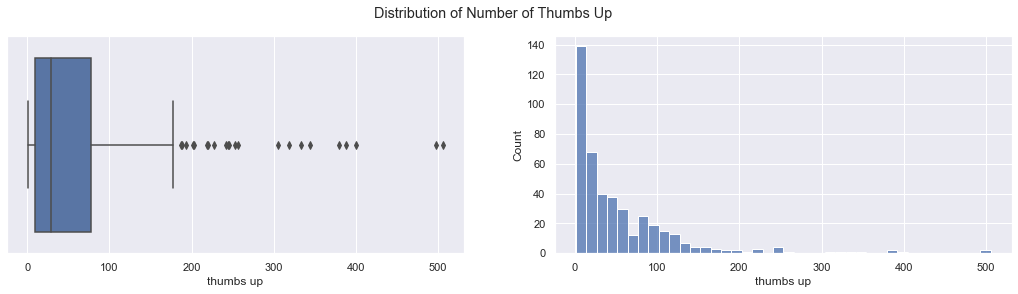

In [57]:
# NUMBER OF THUMBS UP
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = thumbs_up['thumbs up'], ax=axes[0])
sb.histplot(x = thumbs_up['thumbs up'], ax=axes[1], bins=40)
plt.suptitle('Distribution of Number of Thumbs Up')
plt.show()

The average number of thumbs up is 29. Approximately 140 users have 12 thumbs up, which is the highest.

#### 3.6 Number of songs added to playlist

In [58]:
# For every Add to Playlist page, we count it as 1 song added to playlist for that user
subset5 = data[data["page"] == "Add to Playlist"]
songs_added = subset5.groupby("userId").size().reset_index()
songs_added = songs_added.rename(columns = {0:"songs added to playlist"})
songs_added

,userId,songs added to playlist
0,10,14
1,100,94
2,100001,3
3,100002,3
4,100003,19
...,...,...
423,95,45
424,96,60
425,97,32
426,98,75


In [59]:
songs_added.describe()

,songs added to playlist
count,428.000000
mean,28.852804
std,33.913091
min,1.000000
25%,6.000000
50%,17.000000
75%,39.250000
max,248.000000


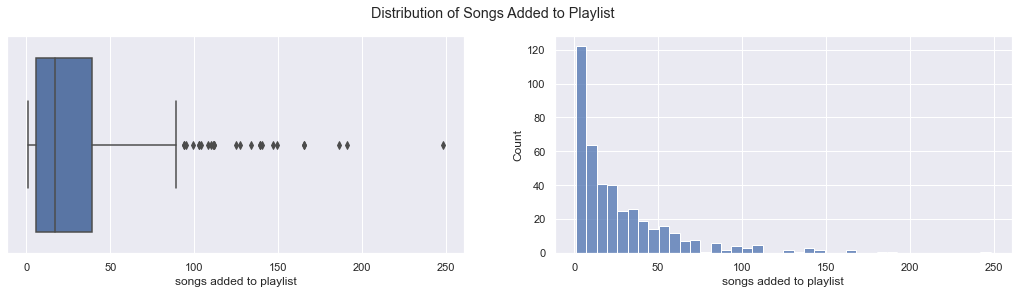

In [60]:
# SONGS ADDED TO PLAYLIST
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = songs_added['songs added to playlist'], ax=axes[0])
sb.histplot(x = songs_added['songs added to playlist'], ax=axes[1], bins=40)
plt.suptitle('Distribution of Songs Added to Playlist')
plt.show()

The average number of songs added to playlist is 17. Approximately 121 users have 6 songs added to playlist, which is the highest.

#### 3.7 Number of upgrades

In [61]:
subset6 = data[data["page"] == "Upgrade"]
# For every Upgrade page, we count it as 1 upgrade for that user
subset6 = data[data["page"] == "Upgrade"]
upgrade = subset6.groupby("userId").size().reset_index()
upgrade = upgrade.rename(columns = {0:"upgrade"})
upgrade

,userId,upgrade
0,100,1
1,100001,2
2,100002,1
3,100003,2
4,100004,2
...,...,...
310,93,1
311,94,1
312,97,10
313,98,4


In [62]:
upgrade.describe()

,upgrade
count,315.000000
mean,3.073016
std,2.527127
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,16.000000


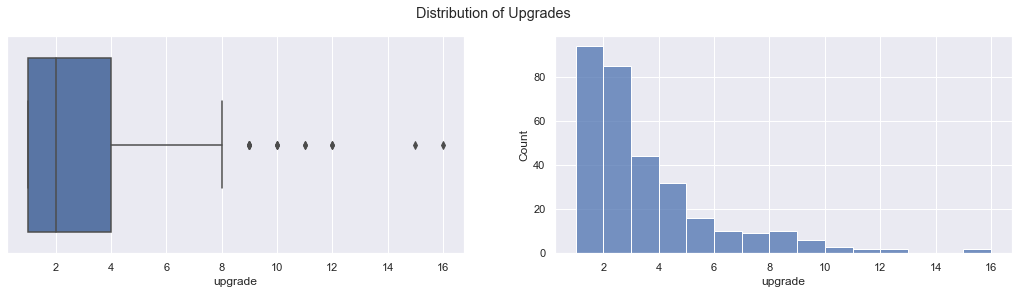

In [63]:
# UPGRADES
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = upgrade['upgrade'], ax=axes[0])
sb.histplot(x = upgrade['upgrade'], ax=axes[1], bins=15)
plt.suptitle('Distribution of Upgrades')
plt.show()

The average number of upgrades is 2. Approximately 90 users have 1 upgrade, which is the highest.

#### 3.8 Number of downgrades

In [64]:
# For every Downgrade page, we count it as 1 downgrade for that user
subset7 = data[data["page"] == "Downgrade"]
downgrade = subset7.groupby("userId").size().reset_index()
downgrade = downgrade.rename(columns = {0:"downgrade"})
downgrade

,userId,downgrade
0,10,1
1,100,40
2,100002,2
3,100003,13
4,100006,1
...,...,...
296,95,16
297,96,18
298,97,1
299,98,30


In [65]:
downgrade.describe()

,downgrade
count,301.00000
mean,12.66113
std,12.52297
min,1.00000
25%,4.00000
50%,9.00000
75%,17.00000
max,85.00000


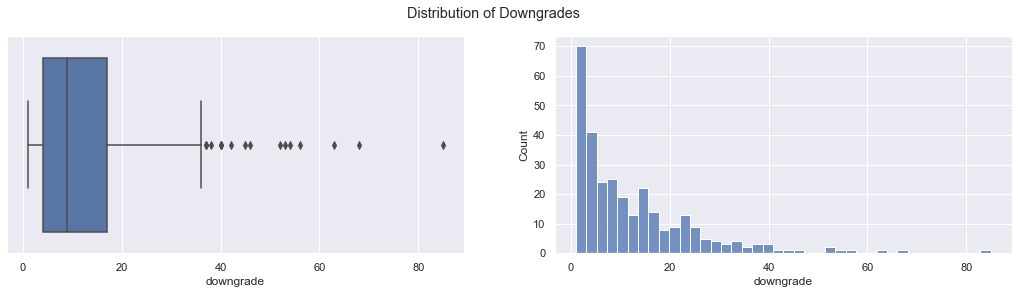

In [66]:
# DOWNGRADES
f, axes = plt.subplots(1, 2, figsize=(18, 4))
sb.boxplot(x = downgrade['downgrade'], ax=axes[0])
sb.histplot(x = downgrade['downgrade'], ax=axes[1], bins=40)
plt.suptitle('Distribution of Downgrades')
plt.show()

The average number of downgrades is 9. Approximately 70 users have 2 downgrade, which is the highest.

## 4. Modelling <a id="model">
[back to top](#top)


### 4.0 Creating New Variables

In [ ]:
#Drop the empty rows. Total users should be 448
unique_artists = unique_artists[unique_artists["userId"] != ""]
upgrade = upgrade[upgrade["userId"] != ""]
songs_added = songs_added[songs_added["userId"] != ""]
thumbs_up = thumbs_up[thumbs_up["userId"] != ""]
thumbs_down = thumbs_down[thumbs_down["userId"] != ""]
friends = friends[friends["userId"] != ""]
individual_gender = individual_gender[individual_gender["userId"] != ""]
days_since_registration = days_since_registration[days_since_registration["userId"] != ""]
averagesongs_day = averagesongs_day[averagesongs_day["userId"] != ""]
averagesongs_month = averagesongs_month[averagesongs_month["userId"] != ""]
session_month = session_month[session_month["userId"] != ""]
churn_df = churn_df[churn_df["userId"] != ""]

List of variables created: 
upgrade,
songs_added,
thumbs_up,
thumbs_down,
friends,
unique_artists,
individual_gender,
days_since_registration,
averagesongs_day,
averagesongs_month,
session_month,
session_day,


In [ ]:
#merge tables into a single Dataframe
temp = unique_artists.copy()
temp = temp.merge(upgrade,how = "left", on = "userId")
temp = temp.merge(songs_added,how = "left", on = "userId")
temp = temp.merge(thumbs_up,how = "left", on = "userId")
temp = temp.merge(thumbs_down,how = "left", on = "userId")
temp = temp.merge(friends,how = "left", on = "userId")
temp = temp.merge(individual_gender,how = "left", on = "userId")
temp = temp.merge(days_since_registration,how = "left", on = "userId")
temp = temp.merge(averagesongs_day,how = "left", on = "userId")
temp = temp.merge(averagesongs_month,how = "left", on = "userId")
temp = temp.merge(session_month,how = "left", on = "userId")
temp = temp.merge(churn_df, how = "left", on = "userId")
temp = temp.fillna(0)
temp = temp.drop(columns = "userId")

In [68]:
temp["churn"] = temp["churn"].astype(int)

In [69]:
temp.columns

### 4.1 Unsupervised Learning - Clustering


#### 4.1.1 K-means Clustering

In [ ]:
pip install kneed

In [71]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

Note: you may need to restart the kernel to use updated packages.


In [72]:
cluster_df = temp.drop(columns=['churn', 'gender'], axis=1)
cluster_df

scaler = StandardScaler()
scaled_cluster_df = scaler.fit_transform(cluster_df)

In [73]:
kmeans_kwargs = {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state": 42
}

sse = list()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_cluster_df)
    sse.append(kmeans.inertia_)

To determine the optimal number of clusters, we iterate over 1-10 clusters and check for how the sum of sqaured errors (within group) changes. As expected, the within-group SSE decreases with increasing cluster groups, and to find the most optimal clusters, we use the KneeLocator class to find the kink in the decreasing SSE.

In [ ]:
plt.plot(range(1,10), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

kl = KneeLocator(range(1,10), sse, curve="convex", direction="decreasing")
print('The optimal number of clusters is {}'.format(kl.elbow))

The silhouette score can also help affirm that there is not much to be gained beyond 3 clutsers. Specifically, the silhouette score is calculated using the following formula:

**Silhouette Score** = (b-a)/max(a,b)
where

a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.


In [ ]:
sil_score = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_cluster_df)
    score = silhouette_score(scaled_cluster_df, kmeans.labels_)
    sil_score.append(score)

In [76]:
plt.plot(range(2, 10), sil_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

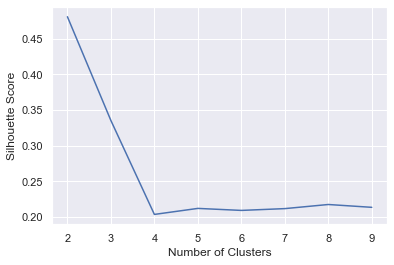

In [77]:
# Let's use 3 clusters

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(scaled_cluster_df)
cluster_df['class'] = kmeans.labels_

In [78]:
cluster_df

In [79]:
cluster_df['churn'] = temp['churn']
cluster_df['gender'] = temp['gender']

,artist,upgrade,songs added to playlist,thumbs up,thumbs down,friends,days_since_registration,song per day,song per month,session per month,class
0,306,0.0,14.0,17.0,1.0,3.0,10,0.855107,350.000000,1.000000,2
1,1963,1.0,94.0,143.0,37.0,71.0,65,0.848896,1007.333333,13.333333,0
2,93,2.0,3.0,5.0,1.0,1.0,44,0.721805,96.000000,3.000000,2
3,128,1.0,3.0,8.0,2.0,0.0,129,0.778409,68.500000,2.000000,2
4,545,2.0,19.0,16.0,10.0,8.0,50,0.808068,322.500000,4.500000,2
...,...,...,...,...,...,...,...,...,...,...,...
443,1329,0.0,45.0,122.0,21.0,38.0,59,0.845082,940.000000,15.500000,1
444,1339,0.0,60.0,78.0,20.0,36.0,70,0.848195,905.500000,9.000000,1
445,905,10.0,32.0,64.0,10.0,24.0,86,0.779145,569.000000,14.500000,1
446,1678,4.0,75.0,131.0,31.0,39.0,63,0.838901,809.666667,10.000000,1


In [80]:
cluster_df['gender'] = cluster_df['gender'].map({'M': 1, 'F':0})

In [81]:
print(cluster_df['class'].value_counts())
cluster_df.groupby('class').mean()

It would appear that cluster 0 corresponds to the minority of users who are `MORE ACTIVE` on the app. Cluster 1 corresponds to users who are `NORMAL ACTIVE` on the app. Cluster 2 corresponds to users who are `LESS ACTIVE`. This is consistent with the average of activities as seen in the groupby results above. It would also appear that those in class 2 (`LESS ACTIVE`) have a slightly higher likelihood of churn. This is consistent with the hypothesis that those who are less engaged by the app will be more likely to churn.

In [ ]:
cols = cluster_df.columns[:-1]

for ii in range(10):
    col = cols[ii]
    sb.distplot(cluster_df[cluster_df['class'] == 0][col], label=0)
    sb.distplot(cluster_df[cluster_df['class'] == 1][col], label=1)
    sb.distplot(cluster_df[cluster_df['class'] == 2][col], label=2)
    plt.legend()
    plt.show()

Alternatively, we can use the DBSCAN algorithm. The DBSCAN algorithm is useful because it is able to isolate out the outliers and not consider them part of our analysis.

#### 4.1.2 DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [84]:
dbscan = DBSCAN(eps=0.85)
dbscan.fit(scaled_cluster_df)

In [85]:
# note noisy samples are given the -1 label
cluster_df['dbscan_class'] = dbscan.labels_

DBSCAN(eps=0.85)

In [86]:
print(cluster_df['dbscan_class'].value_counts())
cluster_df.drop(columns='class', axis=1).groupby('dbscan_class').mean()

It would appear that using the DBSCAN algorithm, those in dbscan_class 2 have a disproportionately higher chance of churn. 

#### 4.1.3 Clustering Results and Actionables

The first clustering model for KMeans shows that there is no discernable difference between the classes in terms of churn. However, in terms of other variables, there are distinct differences when it comes to level of engagement. Similarly, for the DBSCAN clustering, we see 3 clusters with different levels of engagement. Therefore, this can still help to inform business decisions about how the consumer segments exist in Sparkify, and how to have differentiated engagement stratgies for different groups.

### 4.2 Supervised Learning - Logistic Regression and Random Forest Classifier

#### 4.2.0 Motivation for the selected ML algorithms

Classification Model : Random Forest Classifier and Logistic Regression
The purpose of this modelling is to predict potential churn customers so that as a business we are able to take action to intervene and prevent churn. From a businness point of view, we would like to choose models that are able to offer some form of interpretation.
On one hand, we have logistic regression where the estimated coefficients can be used to understand relative feature importances in our model. However, one assumption of the logistic regression is that the data is linearly separable. On the other hand, we might want to have a model that allows for non-linearities but is still able to offer some interptation. This is where the random forest classifier is useful since it allows us to obtain feature importances after the random forest is fit.

Calculation of Feature Importance
A Random Forest comprises of a set of Decision Trees. In each tree, the nodes are selected with a criteria, and in the default RandomForestClassifer() object, the criterion is by default equal to gini. So, for each feature in our dataset, we calculate how much the impurity of the node decreases on average, which gives us our measurement of feature importance. Using this calculation, we can look at the relative feature importances to understand which features are important in determining churn probabilities.

#### 4.2.1 Procesing the categorical and numerical columns

In [88]:
#importing all the functions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

In [89]:
numeric_features = ['artist', 'upgrade', 'songs added to playlist', 'thumbs up',
       'thumbs down', 'friends', 'days_since_registration',
       'song per day', 'song per month', 'session per month']
categorical_features = ["gender"]

In [90]:
#Pipeline for forest regression classification
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model_RFC = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier())])

In [91]:
# Extract Response and Predictors
y = pd.DataFrame(temp['churn'])
X = pd.DataFrame(temp.drop('churn', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 3, test_size = 0.2)
model_RFC.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['artist', 'upgrade',
                                                   'songs added to playlist',
                                                   'thumbs up', 'thumbs down',
                                                   'friends',
                                                   'days_since_registration',
                                                   'song per day',
                                                   'song per month',
                                                   'session per month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                

Accuracy of forest regression classifier on test set: 0.82
TPR :	 0.3684210526315789
FPR :	 0.056338028169014086
Precision :	 0.64
Recall :	 0.37


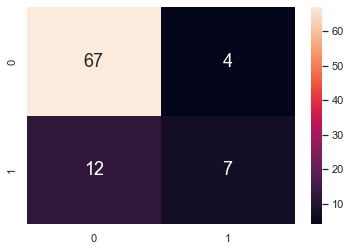

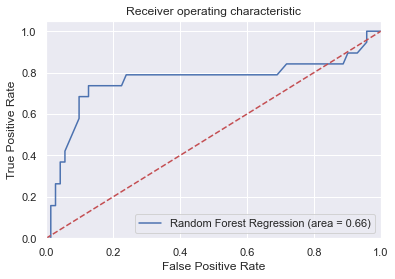

In [92]:
## Random Forest Classification training and fitting
model_RFC.fit(X_train, y_train)

y_pred = model_RFC.predict(X_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model_RFC.score(X_test, y_test)))


# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

#explain why we care more about recall and precision --> we are able to identify 4 ppl out of 10 who wants to churn 
#--> able to prevent 

score = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_RFC.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

#### 4.2.2 Stratified train-test split

In our classification problem, we have imbalanced numbers for each churn and non-churn class. When we have small datasets with small number of churn observations, the proportion of churn in train and test datasets can differ quite significantly, which will not give us a good estimate of our model's performance. If we train and test on drastically different subgroups, our model would most likely perform poorly for out-of-sample data.

Stratified train-test split allows us to split into train and test sets such that the proportion of churn and nonchurn in each of the train and test sets is the same. We do this by specifying ```stratify = y["churn"]``` to tell the splitter that we want to split to preserve the proportion of churn.

In [93]:
model_RFC_stratify = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier())])

In [94]:
# Extract Response and Predictors
y = pd.DataFrame(temp['churn'])
X = pd.DataFrame(temp.drop('churn', axis = 1))


#X_train and y_train are for non-upsample training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 3, stratify = y["churn"])
model_RFC_stratify.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['artist', 'upgrade',
                                                   'songs added to playlist',
                                                   'thumbs up', 'thumbs down',
                                                   'friends',
                                                   'days_since_registration',
                                                   'song per day',
                                                   'song per month',
                                                   'session per month']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                

Accuracy of forest regression classifier on test set: 0.82
TPR :	 0.2
FPR :	 0.0
Precision :	 1.0
Recall :	 0.2


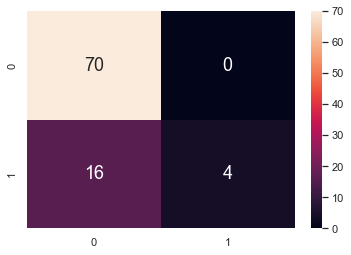

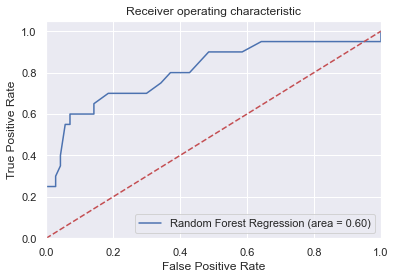

In [95]:
## Random Forest Classification training and fitting
model_RFC_stratify.fit(X_train, y_train)

y_pred = model_RFC_stratify.predict(X_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model_RFC_stratify.score(X_test, y_test)))


# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

#explain why we care more about recall and precision --> we are able to identify 4 ppl out of 10 who wants to churn 
#--> able to prevent 

score = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_RFC_stratify.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

#### 4.2.3 Churn class Up-Sampling

In addition to stratified train-test split, we also use upsampling to tackle the problem of imbalance datasets. Why is imbalanced data a problem for training our model? This is because our model might become more biased towards prediting the majority class, which in this case are the non-churn users. However, what we really care about is identifying the churn users, so in order to improve our recall rate, we might want to artificially increase the number of churn observations to reduce the type 2 errors. 

To do this, we upsample so that we artifically create more of the minority class (churn), so that we have equal number of churn and non-churn afterwards to prevent our model from being biased towards predicting the majority non-churn group. For this purpose, we do manual upsampling using the ```resample``` function but for other cases, we might want to use techniques such as SMOTE (Synthetic Minority Oversahmpling Technique) to create more diverse and realistic upsampled datasets

In [96]:
temp["churn"].value_counts()

0    349
1     99
Name: churn, dtype: int64

In [97]:
churnsubset = temp[temp["churn"] == True]
nonchurnsubset = temp[temp["churn"] == False]
churnupsample = resample(churnsubset, replace = True, n_samples = len(nonchurnsubset),  random_state = 3)
churnupsample = churnupsample.reset_index(drop = True)
newtemp = pd.concat([churnupsample,nonchurnsubset])
newtemp = newtemp.reset_index()

In [98]:
# Extract Response and Predictors and upsample the training set
y1 = pd.DataFrame(temp['churn'])
X1 = pd.DataFrame(temp.drop('churn', axis = 1))

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2,random_state = 3, stratify = y1["churn"])
trainsample = X1_train
trainsample["churn"] = y1_train["churn"]

train_churnsubset = trainsample[trainsample["churn"] == True]
train_nonchurnsubset = trainsample[trainsample["churn"] == False]
train_churnupsample = resample(train_churnsubset, replace = True, n_samples = len(train_nonchurnsubset),  random_state = 3)
trainupsample = pd.concat([train_nonchurnsubset,train_churnupsample])

In [99]:
#Splitting back into X1_train and y1_train
X1_train = pd.DataFrame(trainupsample.drop('churn', axis = 1))
y1_train = pd.DataFrame(trainupsample['churn'])

### 4.3 Modelling

#### 4.3.1 UDFs for training and evaluation

Accuracy of forest regression classifier on test set: 0.81
TPR :	 0.2
FPR :	 0.014285714285714285
Precision :	 0.8
Recall :	 0.2


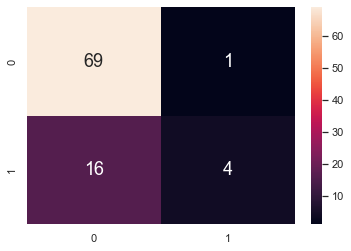

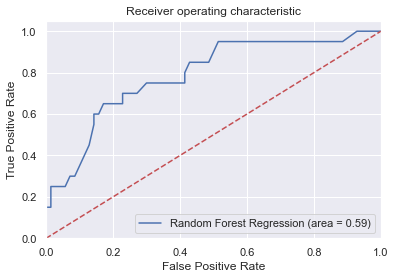

In [100]:
## Random Forest Classification training and fitting
model_RFC.fit(X1_train, y1_train)

y1_pred = model_RFC.predict(X1_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model_RFC.score(X1_test, y1_test)))


# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

#explain why we care more about recall and precision --> we are able to identify 4 ppl out of 10 who wants to churn 
#--> able to prevent 

score = roc_auc_score(y1_test, y1_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_RFC.predict_proba(X1_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

#### 4.3.2 Defining Models & Search-space

In [101]:
#creating columns for male and female to use logistic regression
X1_train["gender"] = label_encoder.fit_transform(X1_train["gender"])
X1_train[["female", "male"]] = one_hot_encoder.fit_transform(X1_train["gender"].values.reshape(-1,1))
X1_train = X1_train.drop(columns = "gender")
X1_train

,artist,upgrade,songs added to playlist,thumbs up,thumbs down,friends,days_since_registration,song per day,song per month,session per month,female,male
309,814,3.0,34.0,56.0,9.0,15.0,137,0.814318,345.333333,9.000000,0.0,1.0
160,155,0.0,6.0,10.0,0.0,0.0,34,0.768519,83.000000,1.500000,1.0,0.0
35,153,0.0,5.0,9.0,1.0,0.0,47,0.874346,81.000000,1.000000,1.0,0.0
365,593,0.0,26.0,66.0,3.0,22.0,86,0.820946,353.000000,4.500000,0.0,1.0
330,793,7.0,43.0,88.0,9.0,20.0,78,0.805359,331.333333,3.666667,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
367,436,0.0,15.0,41.0,4.0,12.0,72,0.815267,511.000000,7.000000,1.0,0.0
324,188,2.0,6.0,16.0,2.0,6.0,71,0.770115,199.000000,3.000000,1.0,0.0
382,516,5.0,20.0,25.0,9.0,16.0,115,0.793190,594.000000,14.000000,1.0,0.0
125,185,0.0,8.0,10.0,4.0,0.0,136,0.771318,98.500000,4.000000,1.0,0.0


In [102]:
X1_test["gender"] = label_encoder.fit_transform(X1_test["gender"])
X1_test[["female", "male"]] = one_hot_encoder.fit_transform(X1_test["gender"].values.reshape(-1,1))
X1_test = X1_test.drop(columns = "gender")
X1_test

,artist,upgrade,songs added to playlist,thumbs up,thumbs down,friends,days_since_registration,song per day,song per month,session per month,female,male
167,1004,12.0,40.0,80.0,42.0,16.0,67,0.774228,671.000000,16.000000,0.0,1.0
320,332,0.0,13.0,23.0,6.0,6.0,114,0.841060,186.500000,2.000000,0.0,1.0
163,155,0.0,5.0,10.0,2.0,6.0,6,0.807882,159.000000,2.000000,0.0,1.0
141,662,7.0,16.0,40.0,7.0,10.0,113,0.760810,400.500000,13.500000,1.0,0.0
150,50,0.0,4.0,3.0,0.0,1.0,54,0.822581,25.500000,1.500000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1,1963,1.0,94.0,143.0,37.0,71.0,65,0.848896,1007.333333,13.333333,0.0,1.0
363,41,0.0,0.0,2.0,0.0,0.0,32,0.811321,21.000000,1.500000,0.0,1.0
179,211,1.0,5.0,13.0,8.0,2.0,14,0.788194,219.000000,3.000000,1.0,0.0
271,53,1.0,1.0,2.0,2.0,1.0,54,0.785714,55.000000,2.000000,1.0,0.0


Accuracy of logistic regression classifier on test set: 0.80
TPR :	 0.85
FPR :	 0.21428571428571427
Precision :	 0.53
Recall :	 0.85


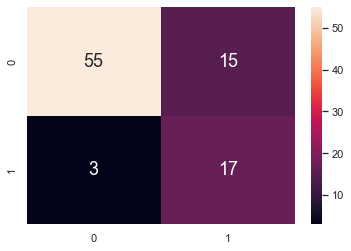

In [103]:
logreg = LogisticRegression()
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

#### 4.3.3 Fitting, Hyperparameter Tuning & Evaluation

#### 4.3.3.1 GridSearchCV (On training set)

## What is GridSearchCV?

The `GridSearchCV` class is a way of implementing grid search for hyperparmeter optimization, by choosing the hyperparameter set that returns the lowest errors. The way to calcualte the errors is through a process of cross-validation.



In [140]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png")

As seen in the figure above, what cross-validation does is that it breaks up the training data into folds (5 folds in this illustration). Subsequently, for each split, it selects one fold as the validation data while using the others as training data. It calculates the errors for each of this splits and takes the average of all the errors as the mean-test-error of the whole run for a specific hyperparameter combination.

Subsequently, we choose the model with the lowest cross-validated test-error and test its performance with the test dataset as we have done so above for both random forest and logistic regressions.

In [104]:
from sklearn.model_selection import GridSearchCV

In [132]:
# GridSearch for RFC
param_grid = {'max_depth': [1, 2, 3, 4],
              'min_samples_split': [2, 5, 10]}

In [133]:
rfc_base_estimator = RandomForestClassifier(random_state=0)

In [134]:
grid_search = GridSearchCV(estimator=rfc_base_estimator, param_grid=param_grid,
                           cv=3, verbose=2)
grid_search.fit(preprocessor.fit_transform(X2_train), y2_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=1, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.1s
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=1, min_samples_split=5; total time=   0.1s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.1s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.0s
[CV] END ..................max_depth=1, min_samples_split=10; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.1s
[CV] END ...................max_depth=2, min_sam

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [135]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=4, min_samples_split=5, random_state=0)

Accuracy of forest regression classifier on test set: 0.76
TPR :	 0.6
FPR :	 0.2
Precision :	 0.46
Recall :	 0.6


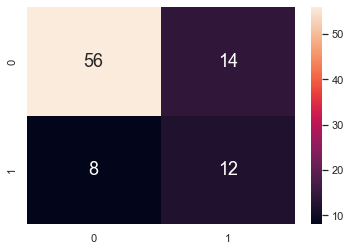

In [136]:
y2_test_pred = best_grid.predict(preprocessor.fit_transform(X2_test))
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(best_grid.score(preprocessor.fit_transform(X2_test), y2_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

In [137]:
# GridSearch for Logistic Regression
log_param_grid = {'C': [100, 10, 1.0, 0.1, 0.01],
                  'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
log_base_estimator = LogisticRegression(random_state=0)

grid_search = GridSearchCV(estimator=log_base_estimator, param_grid=log_param_grid,
                           cv=3, verbose=2)
grid_search.fit(preprocessor.fit_transform(X2_train), y2_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=100, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=no

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=2)

In [138]:
log_best_grid = grid_search.best_estimator_
log_best_grid

LogisticRegression(C=10, random_state=0, solver='newton-cg')

Accuracy of logistic regression classifier on test set: 0.81
TPR :	 0.85
FPR :	 0.2
Precision :	 0.55
Recall :	 0.85


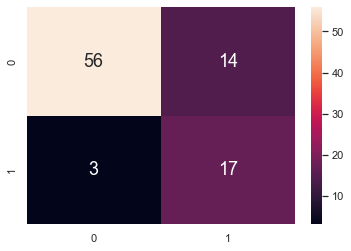

In [139]:
logreg = LogisticRegression(C=10, random_state=0, solver='newton-cg')
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

#### 4.3.3.2 Hyperparameter tuning on training set

Accuracy of logistic regression classifier on test set: 0.82
TPR :	 0.9
FPR :	 0.2
Precision :	 0.56
Recall :	 0.9


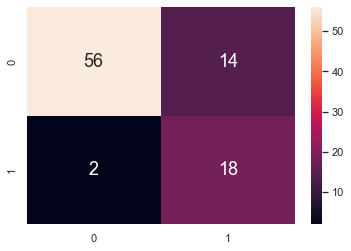

In [105]:
#Attempt 1: change C
logreg = LogisticRegression(C = 0.1)
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of logistic regression classifier on test set: 0.81
TPR :	 0.9
FPR :	 0.21428571428571427
Precision :	 0.55
Recall :	 0.9


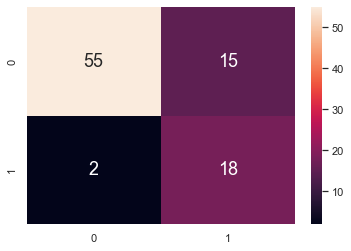

In [106]:
#Attempt 2: change C
logreg = LogisticRegression(C = 0.5)
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of logistic regression classifier on test set: 0.81
TPR :	 0.9
FPR :	 0.21428571428571427
Precision :	 0.55
Recall :	 0.9


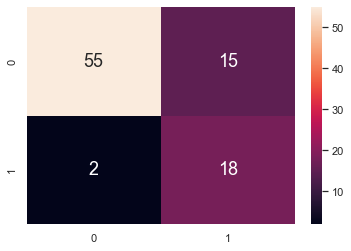

In [107]:
#Attempt 3: change penalty
logreg = LogisticRegression(penalty="none", C = 0.5)
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of logistic regression classifier on test set: 0.81
TPR :	 0.9
FPR :	 0.21428571428571427
Precision :	 0.55
Recall :	 0.9


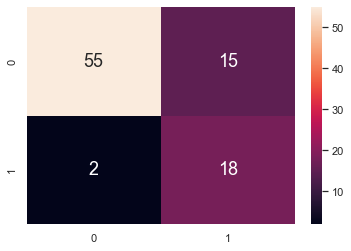

In [108]:
#Attempt 4: change penalty
logreg = LogisticRegression(penalty="l2", C = 0.5)
logreg.fit(X1_train, y1_train)
y1_pred = logreg.predict(X1_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X1_test, y1_test)))

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y1_test, y1_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y1_test, y1_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

In [109]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X1, y1, test_size = 0.2,random_state = 3, stratify = y1["churn"])
trainsample = X2_train
trainsample["churn"] = y2_train["churn"]

train_churnsubset = trainsample[trainsample["churn"] == True]
train_nonchurnsubset = trainsample[trainsample["churn"] == False]
train_churnupsample = resample(train_churnsubset, replace = True, n_samples = len(train_nonchurnsubset),  random_state = 3)
trainupsample = pd.concat([train_nonchurnsubset,train_churnupsample])
X2_train = pd.DataFrame(trainupsample.drop('churn', axis = 1))
y2_train = pd.DataFrame(trainupsample['churn'])
X2_train

,artist,upgrade,songs added to playlist,thumbs up,thumbs down,friends,gender,days_since_registration,song per day,song per month,session per month
309,814,3.0,34.0,56.0,9.0,15.0,M,137,0.814318,345.333333,9.000000
160,155,0.0,6.0,10.0,0.0,0.0,F,34,0.768519,83.000000,1.500000
35,153,0.0,5.0,9.0,1.0,0.0,F,47,0.874346,81.000000,1.000000
365,593,0.0,26.0,66.0,3.0,22.0,M,86,0.820946,353.000000,4.500000
330,793,7.0,43.0,88.0,9.0,20.0,M,78,0.805359,331.333333,3.666667
...,...,...,...,...,...,...,...,...,...,...,...
367,436,0.0,15.0,41.0,4.0,12.0,F,72,0.815267,511.000000,7.000000
324,188,2.0,6.0,16.0,2.0,6.0,F,71,0.770115,199.000000,3.000000
382,516,5.0,20.0,25.0,9.0,16.0,F,115,0.793190,594.000000,14.000000
125,185,0.0,8.0,10.0,4.0,0.0,F,136,0.771318,98.500000,4.000000


In [110]:
rfc = model_RFC["model"]

In [111]:
importance = rfc.feature_importances_

In [112]:
X2_train.columns

Index(['artist', 'upgrade', 'songs added to playlist', 'thumbs up',
       'thumbs down', 'friends', 'gender', 'days_since_registration',
       'song per day', 'song per month', 'session per month'],
      dtype='object')

In [113]:
for i in range(11):
    print(X2_train.columns[i])
    print(importance[i])

artist
0.10216010511125356
upgrade
0.046462209218527
songs added to playlist
0.08240629290460022
thumbs up
0.09064231277581435
thumbs down
0.058049381088144836
friends
0.06793619472081969
gender
0.1663291848732268
days_since_registration
0.11364790167515294
song per day
0.15556229442419975
song per month
0.09178423557295282
session per month
0.012665358070847614


Accuracy of forest regression classifier on test set: 0.80
TPR :	 0.65
FPR :	 0.15714285714285714
Precision :	 0.54
Recall :	 0.65


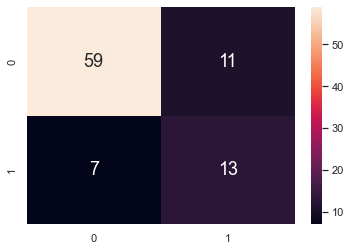

In [141]:
#Attempt 1: change max_depth
model = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier(max_depth = 1))])
model.fit(X2_train, y2_train)

y2_test_pred = model.predict(X2_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model.score(X2_test, y2_test)))
from sklearn.metrics import confusion_matrix

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of forest regression classifier on test set: 0.78
TPR :	 0.6
FPR :	 0.17142857142857143
Precision :	 0.5
Recall :	 0.6


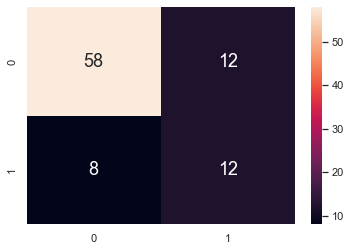

In [142]:
#Attempt 2: change max_depth
model = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier(max_depth = 2))])
model.fit(X2_train, y2_train)

y2_test_pred = model.predict(X2_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model.score(X2_test, y2_test)))
from sklearn.metrics import confusion_matrix

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of forest regression classifier on test set: 0.77
TPR :	 0.5
FPR :	 0.15714285714285714
Precision :	 0.48
Recall :	 0.5


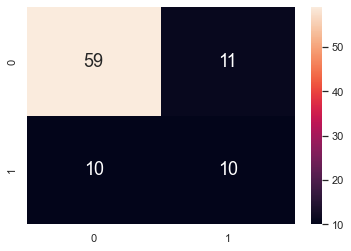

In [143]:
#Attempt 2: change max_depth
model = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier(max_depth = 3))])
model.fit(X2_train, y2_train)

y2_test_pred = model.predict(X2_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model.score(X2_test, y2_test)))
from sklearn.metrics import confusion_matrix

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of forest regression classifier on test set: 0.79
TPR :	 0.2
FPR :	 0.04285714285714286
Precision :	 0.57
Recall :	 0.2


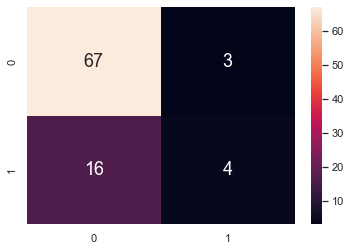

In [145]:
#Attempt 4: change min_samples_split
model = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier(min_samples_split = 2))])
model.fit(X2_train, y2_train)

y2_test_pred = model.predict(X2_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model.score(X2_test, y2_test)))
from sklearn.metrics import confusion_matrix

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

Accuracy of forest regression classifier on test set: 0.80
TPR :	 0.25
FPR :	 0.04285714285714286
Precision :	 0.62
Recall :	 0.25


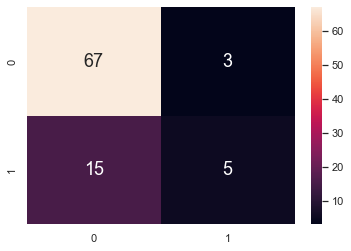

In [146]:
#Attempt 5: change min_samples_split
model = Pipeline([('preprocessor', preprocessor),('model', RandomForestClassifier(min_samples_split = 5))])
model.fit(X2_train, y2_train)

y2_test_pred = model.predict(X2_test)
print('Accuracy of forest regression classifier on test set: {:.2f}'.format(model.score(X2_test, y2_test)))
from sklearn.metrics import confusion_matrix

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y2_test, y2_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR :\t", (tpTest/(tpTest + fnTest)))
print("FPR :\t", (fpTest/(tnTest + fpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y2_test, y2_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

print("Precision :\t", round(tpTest/(tpTest + fpTest),2))
print("Recall :\t", round(tpTest/(tpTest + fnTest),2))

From the hyperparameter tuning, we can see that the max_depth and min_samples_split does affect the Random Forest Regression Classification significantly whereby the best result is with max_depth = 2.
From the hyperparameter tuning of penalty and c, we can see that those hyperparameters do not affect the logistic regression results significantly.


### 4.4 Model Diagnostics

From the various hyperparameter tuning, we observed that our best model is the Logistic Regression model as compared to the Random Forest Classifier given that the recall rate is significantly higher for Logistic Regression than Random Forest Classifier. For the specific hyperparameters, we decided to use the Attempt 1 Model (where C = 0.1) since it has a slightly better precision and False Positive Rate.

## 5. Value Proposition <a id="value">
[back to top](#top)

In the best performing model, we are able to identify 18 out of 20 churn users accurately. If we are able to offer sufficient incentives to retain these potential churn users, this means that we are able to reduce churn rate by 90%. 

In [127]:
churn_df.groupby('churn').count()

,userId
churn,
False,349
True,99


As we see in the proportion breakdown, this means that out of the 99 churn users, we will be able to retain 90% of them given the right incentives if our model can identify them.

This means that the number of churn users will decrease from 99 users to 99 * 10% = 10 users. 

Consequently, the total number of retained users will increase from 349 to 349 + 99 * 90% = 349 + 89 = 438 users

If we take revenues and profits to be proportionate to the number of users, this will mean that revenues and profits will potentially increased by (438/349)-1 = 25.5%, which is a significant gain for the company.

To obtain a more complete understanding of this project's import on profit, revenue and cost, we can use comparable firms in the market to make assumptions about Sparkify's existing profit margin structure.

A similar firm in the market today is Spotify, and as of December 2021, it's profit margin was 26%. This means that for every `$100` of revenue, it's gross profit is `$26`. This also implies that current cost is `$74`.

According to the WSJ, advertisements account for about 10% of Spotify's revenue. 

If revenues were to increase by 25.5%, the new revenue for every `$90` previously would be `$113`.

For advertisement revenue of `$10`, this would increase not just 25.5% but an addition 7.65/6.5 because as we see below, the sessions per month for churn vs no churn is actually higher for the churn group, which represents more frequent opportunities for showing advertisements.

In [128]:
temp.groupby('churn')['session per month'].mean().reset_index()

,churn,session per month
0,0,6.499045
1,1,7.656566


In [129]:
churn_users = 99
non_churn_users = 349
retention_of_churn_users = 0.9
new_non_churn_users = non_churn_users + retention_of_churn_users * churn_users

non_ad_revenue = 90
ad_revenue = 10
new_non_ad_revenue = non_ad_revenue * (new_non_churn_users)/(non_churn_users)
print('The new non-ad revenue is ${}'.format(round(new_non_ad_revenue)))

additional_ad_revenue = (((new_non_churn_users)/(non_churn_users))-1)*ad_revenue
additional_ad_revenue *= 7.656/6.499
new_ad_revenue = ad_revenue + additional_ad_revenue
print('The new ad revenue is ${}'.format(round(new_ad_revenue)))

print('The total new revenue is ${}'.format(round(new_non_ad_revenue + new_ad_revenue)))

The new non-ad revenue is $113
The new ad revenue is $13
The total new revenue is $126


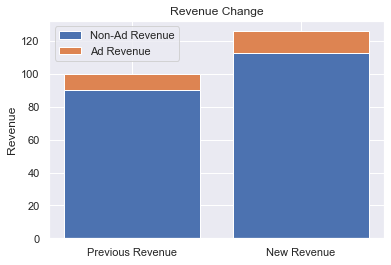

This represents a 26% increase in revenue


In [130]:
fig, ax = plt.subplots()
labels = ['Previous Revenue', 'New Revenue']
non_ad_revenues = [non_ad_revenue, new_non_ad_revenue]
ad_revenues = [ad_revenue, new_ad_revenue]
ax.bar(labels, non_ad_revenues, label='Non-Ad Revenue')
ax.bar(labels, ad_revenues, bottom=non_ad_revenues, label='Ad Revenue')
ax.set_ylabel('Revenue')
ax.set_title('Revenue Change')
ax.legend()
plt.show()

print('This represents a {}% increase in revenue'.format(round(new_non_ad_revenue + new_ad_revenue - 100)))



In [131]:
previous_profit = 26
new_profit = previous_profit + new_non_ad_revenue + new_ad_revenue - 100

print('This represents a {}% increase in profit, assuming cost does not change.'.format(round(100*((new_profit/previous_profit)-1))))


This represents a 100% increase in profit, assuming cost does not change.
